In [1]:
import sys, os
sys.path.insert(0, '/home/niell_lab/Documents/github/FreelyMovingEphys/')
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.stats import linregress
from tqdm import tqdm
from sklearn.neighbors import KernelDensity
from projects.ephys.population import Population
from src.utils.path import find
from src.utils.auxiliary import flatten_series

In [33]:
import matplotlib as mpl
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
%matplotlib inline
mpl.rcParams.update({'font.size':10})

In [2]:
hffm_savepath = '/home/niell_lab/Data/freely_moving_ephys/batch_files/051322'
hffm = Population(savepath=hffm_savepath)
hffm.load(fname='hffm_051322')

reading from /home/niell_lab/Data/freely_moving_ephys/batch_files/051322/hffm_051322.pickle


In [3]:
def apply_win_to_comp_sacc(comp, gazeshift, win=0.25):
    bad_comp = np.array([c for c in comp for g in gazeshift if ((g>(c-win)) & (g<(c+win)))])
    comp_times = np.delete(comp, np.isin(comp, bad_comp))
    return comp_times

In [4]:
saccthresh = { # deg/sec
        'gaze_stationary': 120,
        'gaze_moved': 240
    }

In [30]:
def jitter_ax(center, size):
    return np.ones(size)+np.random.uniform(center-0.2, center+0.2, size)

In [47]:
thresh = 240
num_left_gaze = []
num_right_gaze = []

for s, name in enumerate(hffm.data['session'].unique()):
    dEye = hffm.data['Wn_dEye_dps'][hffm.data['session']==name].iloc[0]
    eyeT = hffm.data['Wn_eyeT'][hffm.data['session']==name].iloc[0][:-1]

    gazeL = eyeT[(dEye > thresh)]
    gazeR = eyeT[(dEye < -thresh)]
    
    minutes = (eyeT.size)/60/60
    
    num_left_gaze.append(len(gazeL)/minutes)
    num_right_gaze.append(len(gazeR)/minutes)

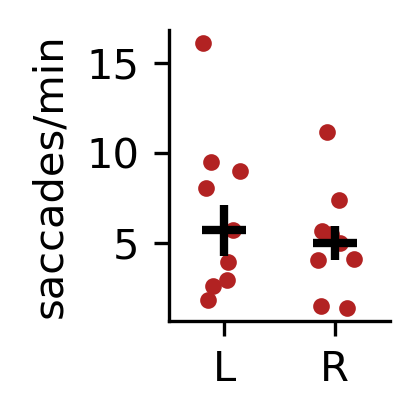

In [49]:
fig, ax = plt.subplots(1,1,figsize=(1.5,1.5),dpi=300)

ax.plot(jitter_ax(0, len(num_left_gaze)), num_left_gaze, '.', color='firebrick')
ax.plot(jitter_ax(1, len(num_right_gaze)), num_right_gaze, '.', color='firebrick')


for i, vals in enumerate([num_left_gaze, num_right_gaze]):
    center = i+1
    med = np.median(vals)
    err = np.std(vals) / np.sqrt(len(vals))
    ax.hlines(med, center-.2, center+.2, color='k', linewidth=2)
    ax.vlines(center, med-err, med+err, color='k', linewidth=2)

ax.set_xticks(np.arange(1,3,1), labels=['L','R'])
ax.set_xlim([0.5,2.5])
# ax.set_yticks(np.linspace(0,24000,6))
# ax.set_ylim([0, 24000])
ax.set_ylabel('saccades/min')

plt.tight_layout()
fig.savefig('/home/niell_lab/Desktop/head-fixed_saccade_rate.pdf')

In [27]:
num_left_gaze

[119, 76, 298, 162, 51, 46, 31, 160, 151]

In [28]:
num_right_gaze

[163, 91, 252, 114, 31, 28, 72, 107, 123]

In [ ]:

    for stim in ['FmLt']:
        for s, name in enumerate(hffm.data['session'].unique()):
            print('{} stim of {} recording'.format(stim, name))
            dHead = hffm.data[stim+'_dHead'][hffm.data['session']==name].iloc[0]
            dGaze = hffm.data[stim+'_dGaze'][hffm.data['session']==name].iloc[0]
            eyeT = hffm.data[stim+'_eyeT'][hffm.data['session']==name].iloc[0][:-1]
            
            gazeL = eyeT[(dHead > saccthresh['head_moved']) & (dGaze > saccthresh['gaze_moved'])]
            gazeR = eyeT[(dHead < -saccthresh['head_moved']) & (dGaze < -saccthresh['gaze_moved'])]

            compL = eyeT[(dHead > saccthresh['head_moved']) & (dGaze < saccthresh['gaze_stationary']) & (dGaze > -saccthresh['gaze_stationary'])]
            compR = eyeT[(dHead < -saccthresh['head_moved']) & (dGaze > -saccthresh['gaze_stationary']) & (dGaze < saccthresh['gaze_stationary'])]
            
            compL = apply_win_to_comp_sacc(compL, gazeL)
            compR = apply_win_to_comp_sacc(compR, gazeR)
            
            # SDFs
            for ind in tqdm(hffm.data[hffm.data['session']==name].index.values):
                spikeT = hffm.data.loc[ind,stim+'_spikeT']
                
                movements = [gazeL, gazeR, compL, compR]
                movkeys = [stim+'_gazeshift_left_saccPSTH_dHead',
                        stim+'_gazeshift_right_saccPSTH_dHead',
                        stim+'_comp_left_saccPSTH_dHead',
                        stim+'_comp_right_saccPSTH_dHead']
                timekeys = [stim+'_gazeshift_left_saccTimes_dHead',
                        stim+'_gazeshift_right_saccTimes_dHead',
                        stim+'_comp_left_saccTimes_dHead',
                        stim+'_comp_right_saccTimes_dHead']
                for x in range(4):
                    movkey = movkeys[x]; timekey = timekeys[x]
                    eventT = movements[x]
                    
                    # save the spike density function
                    _, sdf = calc_kde_sdf(spikeT, eventT)
                    hffm.data.at[ind, movkey] = sdf.astype(object)
                    
                    # save the saccade times
                    hffm.data.at[ind, timekey] = eventT.astype(object)

    # Save new pickle file
    hffm.save(fname='hffm_0411822_sdf', savedir='/home/niell_lab/Desktop/')

if __name__ == '__main__':
    main()